# Amplifying Noise on Optimized VQE Circuit (H2 at 0.74 ang via Simulator) by random addition of both single and 2 qubit gates.

# Also amplifyig readout errors

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_london')
from qiskit.test.mock import FakeLondon
machine = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

In [2]:
machine

<FakeLondon('fake_london') from None()>

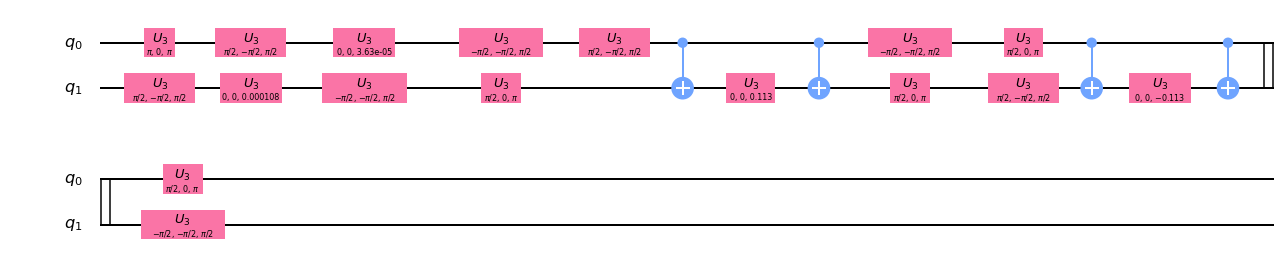

In [3]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
vqe_circ.draw(output = 'mpl')

### Functions for Noise Amplification

In [4]:
def u3PairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    # Converting the gate string to array 
    
    ##break up the string 
    strings = orig_gate_str.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    
    #Obtaining all useful information 
    gate = strings[0]
    qubit = strings[4]
    orig_angles = strings[1:4]
    
    #new angles 
    new_angles = orig_angles 
    
    ## U3 ^-1(  theta,  phi, lambda) = U3( theta , -pi - lambda, - pi - phi)
    
    ###Part 1: Inverting and adding - pi to 2nd and 3rd angle
    for i in range(1,3): 
        if new_angles[i][0] == '-': 
            
            if new_angles[i] == '-pi': 
                new_angles[i] = str(-math.pi +math.pi)
            elif new_angles[i] == '-pi/2': 
                new_angles[i] = str(-math.pi +(math.pi/2))
            else:
                new_angles[i] = str(-math.pi +float(new_angles[i][1:]))
        else: 
            if new_angles[i] == 'pi': 
                new_angles[i] = str(-math.pi -math.pi)
            elif new_angles[i] == 'pi/2': 
                new_angles[i] = str(-math.pi -(math.pi/2))
            else:
                new_angles[i] = str(-math.pi+ (-1)*float(new_angles[i]))
    ###Part 2: Switching the 2nd and 3rd angles
    new_angles = [new_angles[0], new_angles[2], new_angles[1]]
            

    #creating inverted gate
    new_gate_str = gate + '(' + new_angles[0] + ',' + new_angles[1] + ',' + new_angles[2] + ')' + qubit
    
    #barrier 
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n'
    

In [5]:
def cXPairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    #barrier for 2 qubit circuit only
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n'

In [6]:
import random 

def RandomAmplification(circ, c, u3_amp = True): 
    """
    Input: a circuit, and scaling factor between 1 and 3 (inclusive)
    Output: circuit with amplified error rate using adding-pair-of-gates tactic
    """
    
    #probability to add a pair of gates 
    g = (c-1)/4
    
    #iterating over the circuit in string representation
    
    
    newqasm_str=""
    circ_str=circ.qasm()
    
    qregname=circ.qregs[0].name
    
    for line in iter(circ_str.splitlines()):
        
        if line.startswith('cx') or line.startswith('u3'):
            
            #doing a toss to see if we have to amplify 
            if random.randint(1,101) <= 100*g : 
                
                #adding the original line first 
                ##barrier 
                barrier ="""barrier q[0],q[1];"""
                newqasm_str+= barrier + '\n' + line + '\n'+ barrier + '\n'
                if line.startswith('cx'):
                    newqasm_str += cXPairAdder(line)
                else: 
                    if(u3_amp):
                        newqasm_str += u3PairAdder(line)
            else: 
                newqasm_str+=line+"\n"
        else:
            newqasm_str+=line+"\n"

    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
    return circo 


### Functions for Readout Error Amplification

In [7]:
def one_qubit_readout_error_matrix(qubit_n, scale = 1):
    """
    Input: which qubit on the london device, scale (for noise scaling)
    Generates the readout error matrix
    
    organized as 
    
    P(0|0)  P(0|1)
    P(1|0)  P(1|1)
    
    """
    if (qubit_n == 0): 
        p1_0 = machine.properties().qubit_property(0, 'prob_meas1_prep0')[0]
        p0_1 = machine.properties().qubit_property(0, 'prob_meas0_prep1')[0]
        errors = [p1_0, p0_1]
    elif (qubit_n == 1): 
        p1_0 = machine.properties().qubit_property(1, 'prob_meas1_prep0')[0]
        p0_1 = machine.properties().qubit_property(1, 'prob_meas0_prep1')[0]
        errors = [p1_0, p0_1]
    x, y = errors
    x = scale*x
    y = scale*y
    
    matrix = [[1-x, y], [x, 1-y]]
    
    return matrix

def column_sum_to_1(matrix): 
    """
    Makes sure that columns of a 2x2 matrix sum to 1
    """
    matrix = np.transpose(matrix)
    
    for r in range(len(matrix)):
        summ = 0
        for c in range(len(matrix[r])):
            summ += matrix[r][c]
        for c in range(len(matrix[r])): 
            matrix[r][c] = (matrix[r][c])/summ
            
    matrix = np.transpose(matrix)
    return matrix
        

def two_qubit_readout_error_matrix(mat_1, mat_2):
    """
    Input: corresponding readout error matrices of the 2 qubits
    Output: their kronecker product
    """
    P = mat_1
    Q = mat_2
    
    matrix = column_sum_to_1(np.kron(P,Q))
    return matrix

def get_2_qubit_readout_matrix_regular(scale): 
    """
    for amplifying readout errors
    """
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(1, scale)
    Q_scale = one_qubit_readout_error_matrix(0, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    return R_scale

def get_2_qubit_readout_matrix_after_readout_measurement(scale): 
    """
    for amplifying readout errors
    """
    #what already happened
    P_1 = one_qubit_readout_error_matrix(1)
    Q_1 = one_qubit_readout_error_matrix(0)
    R_1 = two_qubit_readout_error_matrix(P_1, Q_1)
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(1, scale)
    Q_scale = one_qubit_readout_error_matrix(0, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    #what then needs to happen 
    """
    XR_1 = R_scale
    X = R_scale*(R_1)^-1
    """
    inverse = np.linalg.inv(R_1)
    X = np.dot(R_scale, inverse)
    
    return X

def counts_to_array(counts): 
    """
    Turning counts (dict) to array format ...for matrix multiplication
    """
    array = [[counts['00']],[counts['01']], [counts['10']], [counts['10']] ]
    return array
def array_to_counts(array, shots = 1024):
    """
    Turning array into counts(dict)
    """
    #making sure the array has correct number of shots
    summ = 0
    for i in array: 
        summ+=i
    new_array = [(i/summ)*1024 for i in array]
    
    counts = {'00': float(new_array[0]), '01': float(new_array[1]), '10':float(new_array[2]), '11': float(new_array[3])}
    
    return counts

def counts_after_readout_amp(counts, scale):
    """
    Input: Counts, amplification factor
    Output: modified counts
    """
    array = counts_to_array(counts)
    matrix = get_2_qubit_readout_matrix_after_readout_measurement(scale)
    new_array = np.dot(matrix, array)
    
    return array_to_counts(new_array)

### Hammyfication: Breaking Circuits into 2 copies, 1 for II, IZ, ZI and ZZ and the other for XX

In [8]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [9]:
less_circuits = [circuits[0], circuits[4]]

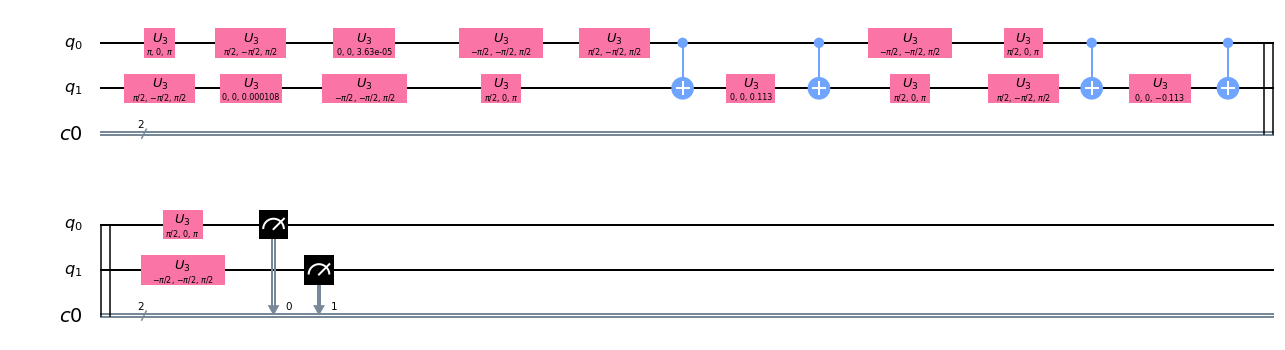

In [10]:
less_circuits[0].draw(output = 'mpl')

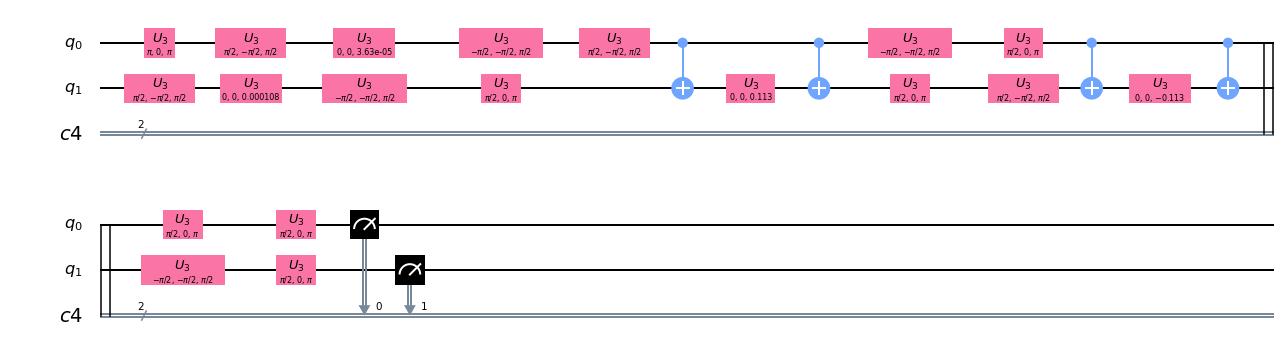

In [11]:
less_circuits[1].draw(output = 'mpl')
#hadamrd in u3 language

### Noise Amplification of Circuits

In [ ]:
lots_scaled_circuits_with_cnot = []
lots_scaled_circuits_with_cnot_and_u3= []
n_samples = 1000
scales = [1,1.5,2,2.5,3, 3.5, 4,4.5, 5]

for c in scales:
    scale_circs_cnot = []
    scale_circs_cnot_and_u3=[]
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in less_circuits: 
        hammyfied_circs_cnot = []
        hammyfied_circs_cnot_and_u3 = []
        print( "Starting Hammified Circ")
        for i in range(n_samples):
            circ = hammyfied_circ.copy()
            amp_circ_cnot_and_u3 = RandomAmplification(circ, c, True)
            amp_circ_cnot = RandomAmplification(circ, c, False)
            hammyfied_circs_cnot.append(amp_circ_cnot)
            hammyfied_circs_cnot_and_u3.append(amp_circ_cnot_and_u3)
        scale_circs_cnot.append(hammyfied_circs_cnot)
        scale_circs_cnot_and_u3.append(hammyfied_circs_cnot_and_u3)
    lots_scaled_circuits_with_cnot.append(scale_circs_cnot)
    lots_scaled_circuits_with_cnot_and_u3.append(scale_circs_cnot_and_u3)

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 1.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 5 

### Expectation Value Functions

In [22]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [23]:
def get_expec_val_H2(results, h, shots = 1024):
    keys = results.keys()
    e_val = 0
    for key in keys:
        counts =int(results[key])
        
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

### Running Circuits

In [24]:
# from qiskit.providers.aer.noise import NoiseModel
# from qiskit.aqua import QuantumInstance
# from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_london')
# noise_model = NoiseModel.from_backend(machine)
# simulator = Aer.get_backend('qasm_simulator')
# noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)

# basis_gates = noise_model.basis_gates

#### Running Function

In [25]:
def evaluator(circuits,
              weights =  [-1.053, 0.395, -0.395, -0.011, 0.181], readout_amp = False, scale = 1):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = []
    noise_model = machine_noise_model
    for circ in circuits: 
        circ = transpile(circ, basis_gates = basis_gates)
        job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
        result = job.result().get_counts()
        results.append(result)
        
    #Amping up readout errors
    if (readout_amp): 
        for i in range(len(results)): 
            results[i] = counts_after_readout_amp(results[i], scale)
    
    #Converting counts to expec values of local hammys
    
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    hammyfied_vals = []
    for i in range(n): 
        if (i <4):
            c = 0
        else: 
            c= 1
        hammyfied_val = get_expec_val_H2(results[c], i)
        hammyfied_vals.append(hammyfied_val)
    
    #Combining expectation values of local hamiltonians with the weights and adding nuclear repulsion energy
    
    shift = 0.7151043390810812
    expec_val = 0 + shift
    for i in range(len(hammyfied_vals)): 
        expec_val += weights[i]*hammyfied_vals[i]
        
    return expec_val
    

In [26]:
import numpy as np
from qiskit import execute 
from qiskit.compiler import transpile 
from qiskit.tools.monitor import job_monitor

means_cnot = []
means_cnot_and_u3 = []
means_cnot_and_u3_and_readout = []
std_devs_cnot = []
std_devs_cnot_and_u3 = []
std_devs_cnot_and_u3_and_readout = []
errs_cnot = []
errs_cnot_and_u3 = []
errs_cnot_and_u3_and_readout = []


std_devs_with_therm = []
err_on_means_with_therm = []
means_without_therm = []
std_devs_without_therm = []
err_on_means_without_therm = []

#With CNOT ONLY
print('CNOT ONLY')
for s in range(len(scales)):
    
    scale_circs = lots_scaled_circuits_with_cnot[s]
    scale = scales[s]
    
    print('------------------------------Starting Scale ' +str(scale) +'---------------------')
    energies = []
    
    #going over all samples, 1 from iz,Zz,zi,ii box and 1 from xx branch 
    hammy_box_1 = scale_circs[0]
    hammy_box_2 = scale_circs[1]
    
    for i in range(n_samples):
        energy = evaluator([hammy_box_1[i], hammy_box_2[i]], readout_amp = False, scale = scale)
        energies.append(energy)
    
    #adding results to means, std_dves
    means_cnot.append(np.mean(energies))
    std_devs_cnot.append(np.std(energies))
    errs_cnot.append(np.std(energies)/np.sqrt(len(energies)))


#With CNOT and U3 ONLY
print('CNOT AND U3 ONLY')
for s in range(len(scales)):
    
    scale_circs = lots_scaled_circuits_with_cnot_and_u3[s]
    scale = scales[s]
    
    print('------------------------------Starting Scale ' +str(scale) +'---------------------')
    energies = []
    
    #going over all samples, 1 from iz,Zz,zi,ii box and 1 from xx branch 
    hammy_box_1 = scale_circs[0]
    hammy_box_2 = scale_circs[1]
    
    for i in range(n_samples):
        energy = evaluator([hammy_box_1[i], hammy_box_2[i]], readout_amp = False, scale = scale)
        energies.append(energy)
    
    #adding results to means, std_dves
    means_cnot_and_u3.append(np.mean(energies))
    std_devs_cnot_and_u3.append(np.std(energies))
    errs_cnot_and_u3.append(np.std(energies)/np.sqrt(len(energies)))

#With CNOT and U3 and readout
print('CNOT AND U3 ONLY')
for s in range(len(scales)):
    
    scale_circs = lots_scaled_circuits_with_cnot_and_u3[s]
    scale = scales[s]
    
    print('------------------------------Starting Scale ' +str(scale) +'---------------------')
    energies = []
    
    #going over all samples, 1 from iz,Zz,zi,ii box and 1 from xx branch 
    hammy_box_1 = scale_circs[0]
    hammy_box_2 = scale_circs[1]
    
    for i in range(n_samples):
        energy = evaluator([hammy_box_1[i], hammy_box_2[i]], readout_amp = True, scale = scale)
        energies.append(energy)
    
    #adding results to means, std_dves
    means_cnot_and_u3_and_readout.append(np.mean(energies))
    std_devs_cnot_and_u3_and_readout.append(np.std(energies))
    errs_cnot_and_u3_and_readout.append(np.std(energies)/np.sqrt(len(energies)))
    
meanses = [means_cnot ,means_cnot_and_u3, means_cnot_and_u3_and_readout]
std_devses = [std_devs_cnot, std_devs_cnot_and_u3, std_devs_cnot_and_u3_and_readout]
errses=[errs_cnot, errs_cnot_and_u3, errs_cnot_and_u3_and_readout]

CNOT ONLY
------------------------------Starting Scale 1---------------------
------------------------------Starting Scale 1.5---------------------
------------------------------Starting Scale 2---------------------
------------------------------Starting Scale 2.5---------------------
------------------------------Starting Scale 3---------------------
------------------------------Starting Scale 3.5---------------------
------------------------------Starting Scale 4---------------------
------------------------------Starting Scale 4.5---------------------
------------------------------Starting Scale 5---------------------
CNOT AND U3 ONLY
------------------------------Starting Scale 1---------------------
------------------------------Starting Scale 1.5---------------------
------------------------------Starting Scale 2---------------------
------------------------------Starting Scale 2.5---------------------
------------------------------Starting Scale 3---------------------
---------

In [27]:
meanses

[[-1.0588070632626687,
  -1.046083432403294,
  -1.0320726218564187,
  -1.0198174577939187,
  -1.0041299421689187,
  -0.9920759714657938,
  -0.9789830691220438,
  -0.9673956238095437,
  -0.9538862370907938],
 [-1.058827117950169,
  -1.043947467559544,
  -1.0273898269345438,
  -1.0125276003720438,
  -0.9962897331845438,
  -0.9808391882626688,
  -0.9672403484189187,
  -0.9533760710751689,
  -0.9382470788876688],
 [-1.0334488083798563,
  -0.9985451736142313,
  -0.9635934919736062,
  -0.9303810027157937,
  -0.8970708728329811,
  -0.8657503738095437,
  -0.8342945867001686,
  -0.8031846033017311,
  -0.7745445310361062]]

In [28]:
std_devses

[[0.01104446010531656,
  0.018788443291276307,
  0.024898440956208575,
  0.026722610446053244,
  0.027796962238602164,
  0.02708583528250317,
  0.024833244209009453,
  0.02153854995750995,
  0.015320439976280024],
 [0.01093269778211905,
  0.020016008774460345,
  0.02502493527115986,
  0.027024871728978453,
  0.028752427216994877,
  0.02611256472250259,
  0.024617303470599178,
  0.020876067712498572,
  0.015248608247945562],
 [0.011932465533711691,
  0.020709739700285883,
  0.024414712402282594,
  0.0247964959740115,
  0.02582152471638065,
  0.023867643186941925,
  0.021418525434908013,
  0.017720041027362566,
  0.013641171487381152]]

In [29]:
errses

[[0.00034925649459663464,
  0.0005941427448934352,
  0.000787357836088398,
  0.0008450431403493635,
  0.0008790171270767565,
  0.0008565293182086026,
  0.0007852961339165637,
  0.0006811087536305431,
  0.00048447485080940897],
 [0.0003457222596176746,
  0.0006329617739321021,
  0.0007913579375514855,
  0.0008546014813746456,
  0.0009092315826392019,
  0.0008257518007167085,
  0.0007784674881866129,
  0.0006601592255939664,
  0.0004822033321113754],
 [0.0003773376918798564,
  0.0006548994720211624,
  0.0007720609960917412,
  0.0007841340526907173,
  0.0008165483076209619,
  0.0007547611485093647,
  0.0006773132449655783,
  0.0005603568987809578,
  0.0004313717185307128]]

### Adding in some thermal relaxation stuff in it as well

In [39]:
def generateDepolarizingError(gate, qubits, machine = machine):
    """
    Return a depolarizing error
    """
    try:
        gate_error = machine.properties().gate_error(gate, qubits)
        error = depolarizing_error(gate_error, len(qubits))
        return error
    
    except: 
        return None
    
def generateRelaxationError(gate, qubits, t1, t2, amp = 1, custom_t = False, machine = machine):
    """
    Return a relaxation error
    """
    if len(qubits) == 1:
        try:
            if(not custom_t):
                t1 = machine.properties().t1(qubits[0])
                t2 = min(machine.properties().t2(qubits[0]), 2*t1)
                t1 = t1/amp
                t2 = t2/amp
            gate_time = machine.properties().gate_length(gate, qubits)
            error = thermal_relaxation_error(t1, t2, gate_time)
            return error
        except:
            return None
    else:
        try:
            #setting times
            
            if(custom_t):
                t1_a = t1
                t2_a = min(t2, 2*t1)
                t1_b = t1_a
                t2_b = t2_a
            else:
                t1_a = machine.properties().t1(qubits[0])
                t2_a = min(machine.properties().t2(qubits[0]), 2*t1_a)
                t1_b = machine.properties().t1(qubits[1])
                t2_b = min(machine.properties().t2(qubits[1]), 2*t1_b)
            
            t1_a = t1_a/amp
            t2_a = t2_a/amp
            t1_b = t1_b/amp
            t2_b = t2_b/amp
            #finding gate time
            time_cx = machine.properties().gate_length(gate, qubits)
            error = thermal_relaxation_error(t1_a, t2_a, time_cx).expand(thermal_relaxation_error(t1_b, t2_b, time_cx))
            return error
        except:
            return None

def generateNoiseModel(amp = 1, custom_t = False, t1 = None, t2 = None):
    """
    Returns a realistic copy of london noise model with custom t1, t2 times
    """
    
    #initializing noise model
    noise_thermal = NoiseModel()
    
    #for every qubit (5 qubit london machine)
    for q in range(5): 
        
        #types of erroneous gates
        gates = [ 'u3', 'u2', 'id']
        

        for gate in gates: 

            dep_error = generateDepolarizingError(gate, [q])
            rel_error = generateRelaxationError(gate,[q], t1, t2, amp= amp, custom_t = custom_t)

            if(dep_error ==None and rel_error !=None):
                error_obj = rel_error
                noise_thermal.add_quantum_error(error_obj, gate, [q])

            elif(dep_error !=None and rel_error ==None):
                error_obj = dep_error
                noise_thermal.add_quantum_error(error_obj, gate, [q])

            elif(dep_error !=None and rel_error !=None):
                error_obj = dep_error.compose(rel_error)
                noise_thermal.add_quantum_error(error_obj, gate, [q])
        
    
        #2 qubit gate errors
        qubits = [i for i in range(5)]
        qubits.remove(q)
        for j in qubits:
            dep_error = generateDepolarizingError('cx', [q,j])
            rel_error = generateRelaxationError('cx' ,[q,j], t1, t2, amp = amp,custom_t = custom_t)

            if(dep_error ==None and rel_error !=None):
                error_obj = rel_error
                noise_thermal.add_quantum_error(error_obj, 'cx', [q,j])

            elif(dep_error !=None and rel_error ==None):
                error_obj = dep_error
                noise_thermal.add_quantum_error(error_obj, 'cx', [q,j])

            elif(dep_error !=None and rel_error !=None):
                error_obj = dep_error.compose(rel_error)
                noise_thermal.add_quantum_error(error_obj, 'cx', [q,j])
        
        #adding the readout error 
        p1_0 = machine.properties().qubit_property(q, 'prob_meas1_prep0')[0]
        p0_1 = machine.properties().qubit_property(q, 'prob_meas0_prep1')[0]
        
        matrix = [[1-p1_0, p1_0 ], [p0_1, 1-p0_1]]
        error  = ReadoutError(matrix)
        
        noise_thermal.add_readout_error(error, [q])
        
    return noise_thermal

In [40]:
def new_evaluator(circuits, custom_t = False, t1 = None, t2 = None, 
              weights =  [-1.053, 0.395, -0.395, -0.011, 0.181], readout_amp = False, scale = 1):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = []
    noise_model = generateNoiseModel(scale, custom_t, t1, t2)
    for circ in circuits: 
        circ = transpile(circ, basis_gates = noise_model.basis_gates)
        job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
        result = job.result().get_counts()
        results.append(result)
        
    #Amping up readout errors
    if (readout_amp): 
        for i in range(len(results)): 
            results[i] = counts_after_readout_amp(results[i], scale)
    
    #Converting counts to expec values of local hammys
    
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    hammyfied_vals = []
    for i in range(n): 
        if (i <4):
            c = 0
        else: 
            c= 1
        hammyfied_val = get_expec_val_H2(results[c], i)
        hammyfied_vals.append(hammyfied_val)
    
    #Combining expectation values of local hamiltonians with the weights and adding nuclear repulsion energy
    
    shift = 0.7151043390810812
    expec_val = 0 + shift
    for i in range(len(hammyfied_vals)): 
        expec_val += weights[i]*hammyfied_vals[i]
        
    return expec_val

In [41]:
#Running it 
means_therm = []
std_devs_therm= []
errs_therm = []

for s in range(len(scales)):
    
    scale_circs = lots_scaled_circuits_with_cnot_and_u3[s]
    scale = scales[s]
    
    print('------------------------------Starting Scale ' +str(scale) +'---------------------')
    energies = []
    
    #going over all samples, 1 from iz,Zz,zi,ii box and 1 from xx branch 
    hammy_box_1 = scale_circs[0]
    hammy_box_2 = scale_circs[1]
    
    for i in range(n_samples):
        energy = new_evaluator([hammy_box_1[i], hammy_box_2[i]], readout_amp = True, scale = scale)
        energies.append(energy)
    
    #adding results to means, std_dves
    means_therm.append(np.mean(energies))
    std_devs_therm.append(np.std(energies))
    errs_therm.append(np.std(energies)/np.sqrt(len(energies)))
    
meanses.append(means_therm)
std_devses.append(std_devs_therm)
errses.append(errs_therm)

------------------------------Starting Scale 1---------------------
------------------------------Starting Scale 1.5---------------------
------------------------------Starting Scale 2---------------------
------------------------------Starting Scale 2.5---------------------
------------------------------Starting Scale 3---------------------
------------------------------Starting Scale 3.5---------------------
------------------------------Starting Scale 4---------------------
------------------------------Starting Scale 4.5---------------------
------------------------------Starting Scale 5---------------------


In [42]:
meanses

[[-1.0588070632626687,
  -1.046083432403294,
  -1.0320726218564187,
  -1.0198174577939187,
  -1.0041299421689187,
  -0.9920759714657938,
  -0.9789830691220438,
  -0.9673956238095437,
  -0.9538862370907938],
 [-1.058827117950169,
  -1.043947467559544,
  -1.0273898269345438,
  -1.0125276003720438,
  -0.9962897331845438,
  -0.9808391882626688,
  -0.9672403484189187,
  -0.9533760710751689,
  -0.9382470788876688],
 [-1.0334488083798563,
  -0.9985451736142313,
  -0.9635934919736062,
  -0.9303810027157937,
  -0.8970708728329811,
  -0.8657503738095437,
  -0.8342945867001686,
  -0.8031846033017311,
  -0.7745445310361062],
 [-1.0229591492001686,
  -0.9706497908017313,
  -0.9119869079892313,
  -0.8531839304501686,
  -0.7908662585751687,
  -0.7280822361142313,
  -0.6683295593564187,
  -0.6088570046689188,
  -0.5547457898251686]]

### Plotting Results

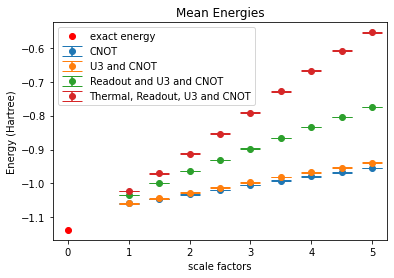

In [57]:
import matplotlib.pyplot as plt


labels= ['CNOT', 'U3 and CNOT', 'Readout and U3 and CNOT', 'Thermal, Readout, U3 and CNOT']

#Plotting means 
d = plt.figure()
for i in range(len(meanses)):
    vqe_mean = meanses[i]
    vqe_err = errses[i]
    labell = labels[i]
    plt.errorbar(scales, vqe_mean, yerr=vqe_err,capsize = 10, fmt ='o', label = labell)
#exact_energy   
plt.plot(0, -1.137, 'ro', label = 'exact energy')

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()
d.savefig('August 17(13)', dpi = 1000)

# Extrapolation

In [44]:
def RichardsonExtrap_Fraction(energies, scales): 
    """
    Input: An array of energies scaled with different stretch factors.
    Output: Zero Error extrapolated answer
    """
    n = len(energies)
    
    #setting up all equations 
    equations = []
    for eq_num in range(1, n+1): 
        equation = []
        
        for term_num in scales: 
            term = term_num**(eq_num)
            print(term)
            equation.append(term)
        equations = np.append(equations, [equation], axis = 0)
    print(equations)
    
    #Now filling up equals to matrix 
    equals_to = [1]
    for i in range(1, n+1): 
        equals_to.append(0)
    #print(equals_to)
    
    #solving the system
    coeff = np.linalg.solve(equations, equals_to)
    #print(coeff)
    
    #Combine coeff with energies to get zero noise result 
    result = np.dot(coeff, energies)
    return result

In [45]:
def MonteCarloError(means, std_devs, poly_fit = False, deg = 1, sampling_size = 1000): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, whether to do richardson i.e. no poly fit 
    If doing polyfit, then specify degree, sampling_size is how many times to sample from the Gaussian 
    
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    zero_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        ##Doing either richardson or funcs 
        ###Polynomial
        if poly_fit: 
            ####need the scale values: 
            scales = []
            scales = [0.5*c +1 for c in range(n)]
            ####making the function 
            param = np.polyfit(scales, energies, deg, w = [1/i for i in std_devs])
            f = np.poly1d(param)
            ####extrapolation
            result = f(0)
            zero_noise_energies.append(result)
            
        ###Richardson
        else: 
            result = RichardsonExtrap_Fraction(energies)
            zero_noise_energies.append(result)
    
    #Returning error i.e. std 
    error = np.std(zero_noise_energies)
    return error

In [46]:
import numpy as np

def plottingCalc(means, std_devs):
    """
    Gives out data for plotting energies for extrapolation purposes
    """
    
    highest_degree = len(means) -1
    
    scales = [1+i*0.5 for i in range(len(means))]
    
    # Uncertainties 
    R_uncert = MonteCarloError(means, std_devs, poly_fit = False)
    
    poly_uncerts = []
    for i in range(1, highest_degree+1): 
        uncert = MonteCarloError(means, std_devs, poly_fit = True, deg = i)
        poly_uncerts.append(uncert)
    
    #O energy extrap
    R_zero = RichardsonExtrap_Fraction(means)
    
    poly_zero = []
    funcs = []
    for i in range(1,highest_degree+1): 
        param= np.polyfit(scales, means, i, w=[1/j for j in std_devs])
        p = np.poly1d(param)
        funcs.append(p)
    for f in range(len(funcs)):
        poly_zero.append(funcs[f](0))
    
    return R_uncert, poly_uncerts, R_zero, poly_zero

In [34]:
exact_energy = [-1.137]

In [50]:
labelses_Poly = [ 'CNOT(Poly)', 'U3 and CNOT (Poly)', 'Readout and U3 and CNOT (Poly)','Thermal and Readout and U3 and CNOT (Poly)' ]
labelses_Rich = [ 'CNOT(Rich)', 'U3 and CNOT (Rich)', 'Readout and U3 and CNOT (Rich)','Thermal and Readout and U3 and CNOT (Rich)' ]
colors_poly = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors_rich = ['cyan', 'pink', 'lightgreen', 'yellow']

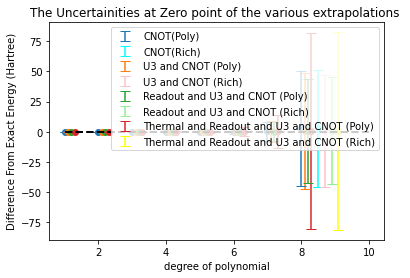

In [55]:
a = plt.figure()
for i in range(4): 
    means = meanses[i]
    std_devs = std_devses[i]
#     label_poly = lablses_Poly[i]
#     label_rich = lablses_Rich[i]
    degrees = [j+1+0.1*i for j in range(len(means)-1)]
    
    R_uncert, poly_uncerts, R_zero, poly_zero = plottingCalc(means, std_devs)
#     print(poly_zero)
#     print(degrees)
    
    plt.errorbar(degrees, [energy - exact_energy[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt =' ', ecolor = colors_poly[i], label = labelses_Poly[i] )
    plt.errorbar(degrees[-1]+.5+.1*i, R_zero- exact_energy[0], yerr=R_uncert, capsize = 5,fmt =' ', ecolor = colors_rich[i] , label = labelses_Rich[i])
    plt.plot(degrees, [energy - exact_energy[0] for energy in poly_zero], linestyle = ' ', marker = 'o', color = colors_poly[i])
    plt.plot(degrees[-1]+.5+.1*i, R_zero- exact_energy[0],  linestyle = ' ', marker = 'o', color = colors_rich[i] )
    

#plt.axis([0.9, 9, 0, 0.07])
    
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
points =[i+1 for i in range(len(meanses[0]))]
points+=[len(meanses[0])+1]
plt.plot(points, [0*i for i in points], linestyle = '--', color = 'black' , linewidth = 2)
plt.legend()
plt.show()
a.savefig('August17 (11)', dpi = 1000)

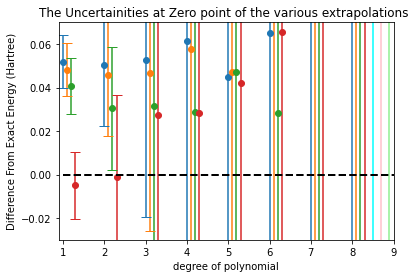

In [56]:
a = plt.figure()
for i in range(4): 
    means = meanses[i]
    std_devs = std_devses[i]
#     label_poly = lablses_Poly[i]
#     label_rich = lablses_Rich[i]
    degrees = [j+1+0.1*i for j in range(len(means)-1)]
    
    R_uncert, poly_uncerts, R_zero, poly_zero = plottingCalc(means, std_devs)
#     print(poly_zero)
#     print(degrees)
    
    plt.errorbar(degrees, [energy - exact_energy[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt =' ', ecolor = colors_poly[i], label = labelses_Poly[i] )
    plt.errorbar(degrees[-1]+.5+.1*i, R_zero- exact_energy[0], yerr=R_uncert, capsize = 5,fmt =' ', ecolor = colors_rich[i] , label = labelses_Rich[i])
    plt.plot(degrees, [energy - exact_energy[0] for energy in poly_zero], linestyle = ' ', marker = 'o', color = colors_poly[i])
    plt.plot(degrees[-1]+.5+.1*i, R_zero- exact_energy[0],  linestyle = ' ', marker = 'o', color = colors_rich[i] )
    

plt.axis([0.9, 9, -0.03, 0.07])
    
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
points =[i+1 for i in range(len(meanses[0]))]
points+=[len(meanses[0])+1]
plt.plot(points, [0*i for i in points], linestyle = '--', color = 'black' , linewidth = 2)
#plt.legend()
plt.show()
a.savefig('August17(12)', dpi = 1000)